### Імпортуємо необхідні бібліотеки для роботи з даними

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, datasets, linear_model, model_selection
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from cmath import sqrt
import pickle

### Читаємо файл із датасетом

In [2]:
dataframe=pd.read_csv('../Dataset.csv')
dataframe.shape

(1467832, 63)

In [3]:
dataframe.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0


Оскільки за умовою завдання нашою метою є прогноз числових значень цільової змінної  (target) 
на основі вибірки з великою кількістю фіч, робимо висновок, що перед нами - <b>задача регресії</b>.

### 1. Очищення даних(Data Cleaning)

Для початку ми перевіримо датасет на наявність пропущених значень

In [4]:
dataframe.isnull().sum().sort_values(ascending=False)

total_sessions_day7        1374
total_sessions_day3        1368
total_sessions_day1        1367
total_sessions_day0        1365
diamonds_spent_session1       0
                           ... 
tickets_spent_day3            0
tickets_spent_day7            0
retained_day1                 0
retained_day3                 0
target_full_ltv_day30         0
Length: 63, dtype: int64

Отже, лише у 4-х метриках(фічах) є пропущені значення: 'total_sessions_day{N}', де N є {0, 1, 3, 7}.

Як можемо побачити, кількість рядків з пропущеними значеннями 1374. Оскільки загальна кількість рядків датасету становить 1467832,
пропущені дані становлять 0.09% від усього датасету, тому раціонально буде знехтувати цією кількістю даних і видалити рядки
із вказаними значеннями.

In [5]:
dataframe = dataframe.dropna()

Нераціональними даними можна вважати ті, у яких ключова змінна target_full_ltv_day30 має від'ємні значення. Дізнаємось,
чи існують такі значення, і якщо так - видалимо їх.

In [6]:
invalid_dataframe = dataframe.loc[(dataframe.target_full_ltv_day30 < 0)]
invalid_dataframe

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
324112,1.0,1.0,1.0,1.0,7,7,7,7,11,11,...,2022-01-28,COUNTRY_123,0.032012,0.032012,0.032012,ios,-2.829604,0.0,0.052409,-2.777195


In [7]:
dataframe = dataframe.drop([324112])
dataframe.shape

(1466457, 63)

Можемо вважати даний етап завершеним.

### 2. Перетворення даних(Data Transformation)

На даному етапі виконується нормалізація даних. Проте цей етап ми не будемо використовувати для нашого датасету.
Для лінійної регресії нормалізація не призводить до покращення моделі.
Вона може бути потрібна лише у тому випадку коли значення "фіч" можуть бути дуже великими, що створює проблеми для обчислень, але у нашому випадку це не так.

### 3. Категоріальні дані(Categorical Data)

Дізнаємось, чи присутні у нашому датасеті категоріальні дані:

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466457 entries, 0 to 1467831
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   total_sessions_day0         1466457 non-null  float64
 1   total_sessions_day1         1466457 non-null  float64
 2   total_sessions_day3         1466457 non-null  float64
 3   total_sessions_day7         1466457 non-null  float64
 4   chapters_finished_day0      1466457 non-null  int64  
 5   chapters_finished_day1      1466457 non-null  int64  
 6   chapters_finished_day3      1466457 non-null  int64  
 7   chapters_finished_day7      1466457 non-null  int64  
 8   chapters_opened_day0        1466457 non-null  int64  
 9   chapters_opened_day1        1466457 non-null  int64  
 10  chapters_opened_day3        1466457 non-null  int64  
 11  chapters_opened_day7        1466457 non-null  int64  
 12  chapters_closed_day0        1466457 non-null  int64  
 1

##### Отже, у нашому датасеті присутні 4 метрики, що представляють категоріальний тип даних:

    platform, media_source, install_date, country_code

З часом гра може ставати більш популярною в якихось країнах або більша кількість гравців може приходити з якогось нового медіаресурсу, що може дуже погано повпливати на модель при майбутньому використанні. Тому ми вирішили, що не варто базувати модель на media_source та country_code.

Стосовно метрики, що представляє дату:  використання дати для лінійної регресії може бути поганим через те, що дохід не є монотонним зі збільшенням дати, адже при лінійній регресії завжди при зростанні параметра, монотонно зростає чи спадає результат.

Але для метрики, що представляє платформу, яку використовує користувач(platform) ми використаємо спосіб Binary Encoding.

Text(0, 0.5, 'Number of users')

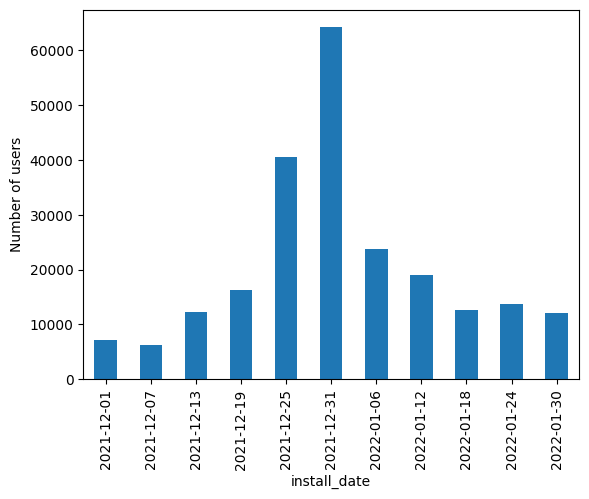

In [9]:
dataframe.groupby('install_date').install_date.count()[::6].plot.bar()
plt.ylabel('Number of users')

In [10]:
dataframe.drop(columns=['media_source','install_date','country_code'],axis=1,inplace=True)
dummies_platform=pd.get_dummies(dataframe['platform'],drop_first=True)
dataframe.drop(columns=['platform'],axis=1,inplace=True)
dataframe=pd.concat([dataframe,dummies_platform],axis='columns')

### 4. Data Reduction

На даному етапі попрацюємо з нашими фічами. Додамо трохи фарб у нашу первинну обробку даних - зобразимо
<b><font color='red'>correlation heatmap</font></b>

<AxesSubplot:>

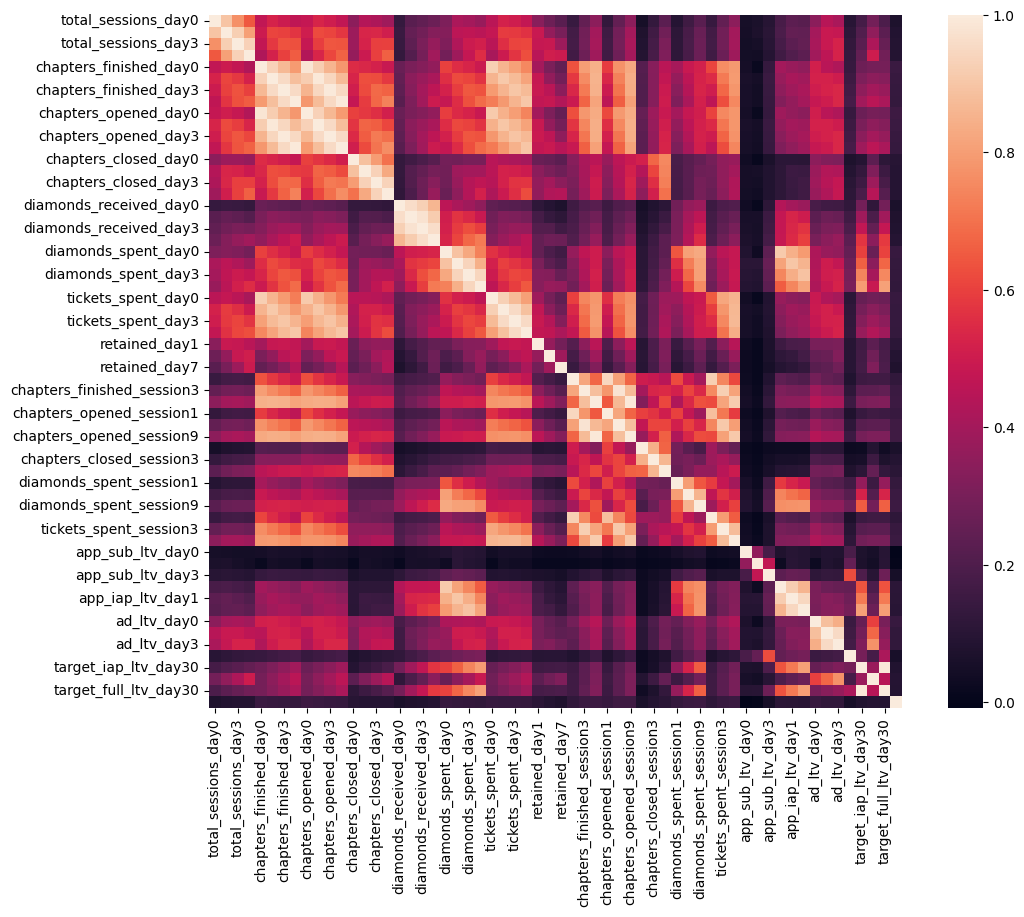

In [11]:
corrmat = dataframe.corr()
fig=plt.figure(figsize=(12,9))
sns.heatmap(corrmat,square=True)

Дослідимо, як залежить середнє значення доходу від некатегоріальних метрик

Відповідні графіки реалізовано у окремому Jupyter Notebook.

З мапи кореляцій можемо побачити, що деякі з фіч сильно корелюють одна з одною. А з графіків бачимо, що середнє значення доходу взагалі не залежить від деяких фіч.

Для того щоб вибрати які з фіч будуть у моделі ми спершу впорядкуємо їх за важливістю, а потім будемо поступово додавати найбільш важливі фічі до моделі у тому випадку якщо вони зменшать метрику MAE на тестових даних.

Відділимо доходи в окремий датафрейм.

In [12]:
income_dataframe=dataframe.filter(['target_sub_ltv_day30','target_iap_ltv_day30','target_ad_ltv_day30','target_full_ltv_day30'],axis=1)
dataframe.drop(columns=['target_sub_ltv_day30','target_iap_ltv_day30','target_ad_ltv_day30','target_full_ltv_day30'],axis=1,inplace=True)

In [13]:
new_dataframe=dataframe.copy()

Натренуємо модель на всіх фічах для того, щоб на основі абсолютних значень коефіцієнтів впорядкувати фічі за "важливістю".

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_dataframe,income_dataframe['target_full_ltv_day30'], test_size=0.2)
model=linear_model.LinearRegression(fit_intercept=1)
model.fit(X_train, y_train)
coef=[]
for i in range(len(model.coef_)):
    coef.append((new_dataframe.columns.values[i], abs(model.coef_[i])))
coef=sorted(coef, key=lambda tup: tup[1])
coef.reverse()
for i in range(len(model.coef_)):
    print(coef[i])

('ad_ltv_day3', 4.228397847277473)
('ad_ltv_day1', 2.4722609056733647)
('app_iap_ltv_day3', 1.6488314905508321)
('app_sub_ltv_day0', 1.334531852308702)
('app_sub_ltv_day3', 1.2989751070461342)
('app_iap_ltv_day1', 0.3852535204261354)
('retained_day7', 0.3588479602781006)
('ad_ltv_day0', 0.25957091944403243)
('app_sub_ltv_day1', 0.239188602187106)
('retained_day3', 0.23060689810231882)
('chapters_closed_day7', 0.17947732395024674)
('app_iap_ltv_day0', 0.1719246847104059)
('chapters_closed_day3', 0.1711279005067208)
('chapters_finished_day3', 0.1277605350182839)
('chapters_finished_day7', 0.090320302704179)
('tickets_spent_day3', 0.09017295491109312)
('retained_day1', 0.08996692109041643)
('tickets_spent_day1', 0.08596553631378503)
('chapters_opened_session9', 0.07291565876853506)
('chapters_closed_session9', 0.06115720114433032)
('chapters_finished_session9', 0.05672703369423865)
('tickets_spent_session1', 0.048190046606344156)
('chapters_closed_day1', 0.040137434463942176)
('chapters_o

Будемо поступово(за "важливістю") додавати фічі в модель і у випадку покращення метрики MAE залишати їх в моделі.

In [31]:
features=[]
min=1000000
best_features=[]
for x in coef:
    name=x[1]
    features.append(x[0])
    training_dataframe=new_dataframe.filter(features,axis='columns')
    X_train, X_test, y_train, y_test = model_selection.train_test_split(training_dataframe,income_dataframe['target_full_ltv_day30'], test_size=0.2)
    model=linear_model.LinearRegression(fit_intercept=1)    
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    a=mean_absolute_error(predictions,y_test)
    if a<min:
        best_features=features.copy()
        min=a
        print(x[0],a)
    else:
        features.remove(x[0])

ad_ltv_day3 0.38146083392553587
ad_ltv_day1 0.3755370369412018
app_iap_ltv_day3 0.12892674324006184
app_sub_ltv_day0 0.1258960599504708


Виведемо "найкращий" список фіч і значення метрики:

In [32]:
print(best_features,min)

['ad_ltv_day3', 'ad_ltv_day1', 'app_iap_ltv_day3', 'app_sub_ltv_day0'] 0.1258960599504708


Водночас бачимо, що модель з фічами 'ad_ltv_day3', 'ad_ltv_day1', 'app_iap_ltv_day3' має майже таку ж метрику MAE. Враховуючи той факт, що фічі 'ad_ltv_day3' та 'ad_ltv_day1' корелюють (як видно з EDA) то можна спробувати викинути одну з них. Викинемо 'ad_ltv_day1', адже вона має меншу "важливість".

In [33]:
training_dataframe=new_dataframe.filter(['ad_ltv_day3','app_iap_ltv_day3'],axis='columns')
print(training_dataframe)
X_train, X_test, y_train, y_test = model_selection.train_test_split(training_dataframe,income_dataframe['target_full_ltv_day30'], test_size=0.2)
model=linear_model.LinearRegression(fit_intercept=1)    
model.fit(X_train, y_train)
predictions=model.predict(X_test)
print(mean_absolute_error(predictions,y_test))
print(sqrt(mean_squared_error(predictions,y_test)))
print(mean_absolute_percentage_error(predictions,y_test))

         ad_ltv_day3  app_iap_ltv_day3
0           0.000000          0.000000
1           0.000000          0.000000
2           0.000000          0.000000
3           0.000000          0.000000
4           0.000000          0.000000
...              ...               ...
1467827     0.037158          4.174198
1467828     0.091267          9.404430
1467829     0.000000         13.928170
1467830     0.177550          7.402224
1467831     0.114909          3.949385

[1466457 rows x 2 columns]
0.1363084012741553
(1.3650698178569645+0j)
3.0754007880493712


Бачимо що метрика MAE не набагато більша за модель з best_features тому виберемо простішу модель. Виведемо її коефіцієнти та візуалізуємо її:

In [35]:
print(model.coef_)
print(model.intercept_)

[3.12427657 1.46897848]
-0.004499131297261483


<class 'numpy.float64'>


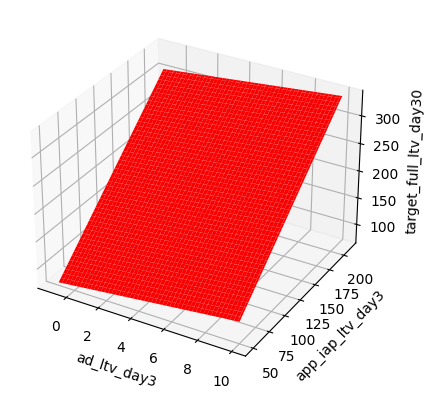

In [36]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.set_xlabel("ad_ltv_day3")
ax.set_ylabel("app_iap_ltv_day3")
ax.set_zlabel("target_full_ltv_day30")
X=np.linspace(-1,10,100)
Y=np.linspace(50,210,100)

X,Y = np.meshgrid(X,Y)

print(type(model.coef_[0]))

Z = model.intercept_ + model.coef_[0]*X + model.coef_[1]*Y
ax.plot_surface(X,Y,Z,color="red")


Збережемо модель у файлі:

In [37]:
saved_model=pickle.dumps(model)
f=open('model','wb')
f.write(saved_model)
f.close()